# State detection pipeline on motion energy 

Binarises motion (here is motion energy but we can do same with eye motion (from SLEAP) into prospective Active/Awake and Rest/Sleep state & performs twitch detection during Rest

Goal: 

- Export annotations and validate 

## Validation:

*** If Manually: Go to excel file named automatic_annotation.xls (that lives in a folder named motion_annotation and open. There you can find onsets and offsets (in frames) for each motion (active, twitch, or unclassified (complex))
You can then add your validated frames on the validated columns. 

- Bonus: Once this is done, we can check how many motions and twitches are TP FP TN (TN we cant have).

*** If in GUI: then load the .avi movie as well as the 'behavior_events_{ds}.xls' (which contains the annotations in binary format) to the GUI. (We need to work on it - add and adjust functionalities)

Bonus2: get % of validated detection and curated onsets and offsets and twithces 


## Once we validate: 

We can check several interesting things:

On the behavior: 

- How do twitches evolve across ages ? (in duraration, amplitude, frequency)
- How much time in awake - sleep we identify per age and how does it evolve ?
- If we track the eye (SLEAP) -> How much correlated the pupil signal is to the motion energy ? Can we identify eye specific motions ? (eg REM, or just twitches).
- If so what % of overlaping - unique eye motions do we find ?
  
On the relationship of behavior with neural activity:

* Once have the onsets - do PMTHs (single and avgs) for twitch and for awake motion
This requires the s2p non avged (rerun on server) 
  
- If detection on non avg - then match back the times /3 and closest ? check carmens ds for other analysis (correlations (motion coupling) vs population coupling, decoding etc.

reminder:
- check maybe sav golay for smoothing better ?  https://scipy-cookbook.readthedocs.io/items/SavitzkyGolay.html
Check onset and offset to be as smooth and not affected by smoothing & avging

- Check twitch bursts -> I think its the step it removes too many twithces

In [1]:
import os
# going to root directory (if not there yet)
current_dir = os.getcwd().split('/')[-1]
if current_dir != 'pixelNMF': 
    os.chdir('..')

In [2]:
os.getcwd()

'D:\\Users\\Max\\Documents\\mouse_motion_analysis'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tifffile
from skimage import filters
from scipy.ndimage import label, binary_closing
from scipy.signal import savgol_filter


from pathlib import Path
from PIL import Image
import imageio
import cv2

from patchnmf.data_io import *
from patchnmf.analyse.videography_compute import *
from patchnmf.analyse.videography_plot import *

In [4]:
os.getcwd()

'D:\\Users\\Max\\Documents\\mouse_motion_analysis'

In [5]:
# setting common plot params 
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [6]:
def mkdir(path):
    if not os.path.exists(path): os.makedirs(path)
    return path

In [7]:
data_path = rf'D:\Users\Max\Documents\data_proc\sz\cells'
# sessions = sorted([f for f in os.listdir(data_path) if f.endswith('_cell_control')])
# print(f'All sessions: {sessions}')

ds = 'sz089\\2024-06-07_a'

subject_path = os.path.join(data_path, ds) # choose one specifc ds 
movie_path = os.path.join(subject_path, 'cam_crop.tif')

In [8]:
# set parameters 
gaussian_sigma = 5

# Thresholds for binarisation
threshold_binary = 'otsu'  # threshold for binary: a/r state detcetion -
threshold_twitch = 'otsu' #threshold for twitch detection (more permissive -> detect more/lose less)
# thresh_factor = 1.0  # used for "mean+std" option

# Twitch detection thresholds
framerate = 3  # (avg!) Hz   # Careful: set rifght framerate (avged or raw motion) (also for time thresholds)
scaling_factor = 5 # for matching back to original time

active_motion_duration_min = framerate * 1 # 1 sec 
long_active_motion_duration_min = framerate * 3 # at least 3 seconds to be considered a long awake motion eg run 
twitch_duration_max = active_motion_duration_min
twitch_min_distance_from_active = framerate * 3  # at least 3 sec away from awake motion to be detected as twitch 
print(f' max_twitch_allowed: {twitch_duration_max/framerate} sec') 

is_sleap = False

 max_twitch_allowed: 1.0 sec


In [9]:
active_motion_duration_min

3

In [10]:
save_dir = subject_path
save_dir_videography = mkdir(f'{save_dir}/motion_annotation_average')
save_dir_videography = Path(save_dir_videography)

# Compute/Load motion energy

In [11]:
def compute_motion_energy(movie_path=None, xrange=None, yrange=None, save_path=None):
    """
    Compute motion energy from a multi-frame TIFF movie of mouse movement.

    Parameters:
    - movie_path: Path to the multi-frame TIFF file (None, unless ititial run)
    - xrange: Range of x-values to crop the image (optional)
    - yrange: Range of y-values to crop the image (optional)
    - save_path: Path to save the motion energy result (optional)
    """
    
    #check if motion energy has already been computed, if that's the case load it

    motion_energy_path = os.path.join(save_path,"motion_energy.npy")
    if os.path.exists(motion_energy_path):

        print(f'Motion energy already computed. Loading from {motion_energy_path}')
        motion_energy = np.load(motion_energy_path)
        return motion_energy

    if not movie_path:

        raise ValueError('Please provide the tiff for the initial run') 
    
    # Load the TIFF movie (multi-frame TIFF)
    movie = tifffile.imread(movie_path)
    num_frames, height, width = movie.shape

    print(f'Loaded movie with {num_frames} frames, height={height}, width={width}')

    # Initialize motion energy array
    motion_energy = np.zeros(num_frames)
    img_prev = movie[0]

    # Iterate over the frames and compute motion energy
    for i in range(1, num_frames):
        img = movie[i]

        # Compute motion energy as squared differences between consecutive frames
        diff = img - img_prev
        squared_diff = diff ** 2
        motion_energy[i] = np.sum(squared_diff)

        # Update img_prev for the next iteration
        img_prev = img

        # Print progress every 1000 frames
        if i % 1000 == 0:
            print(f'Done computing for {i}/{num_frames} frames')
    
    # Normalize motion energy
    motion_energy = motion_energy[1:]  # Skip the first frame (no previous frame to compare)
    motion_energy /= np.max(motion_energy)
    
    return motion_energy

Motion energy already computed. Loading from D:\Users\Max\Documents\data_proc\sz\cells\sz089\2024-06-07_a\motion_energy.npy


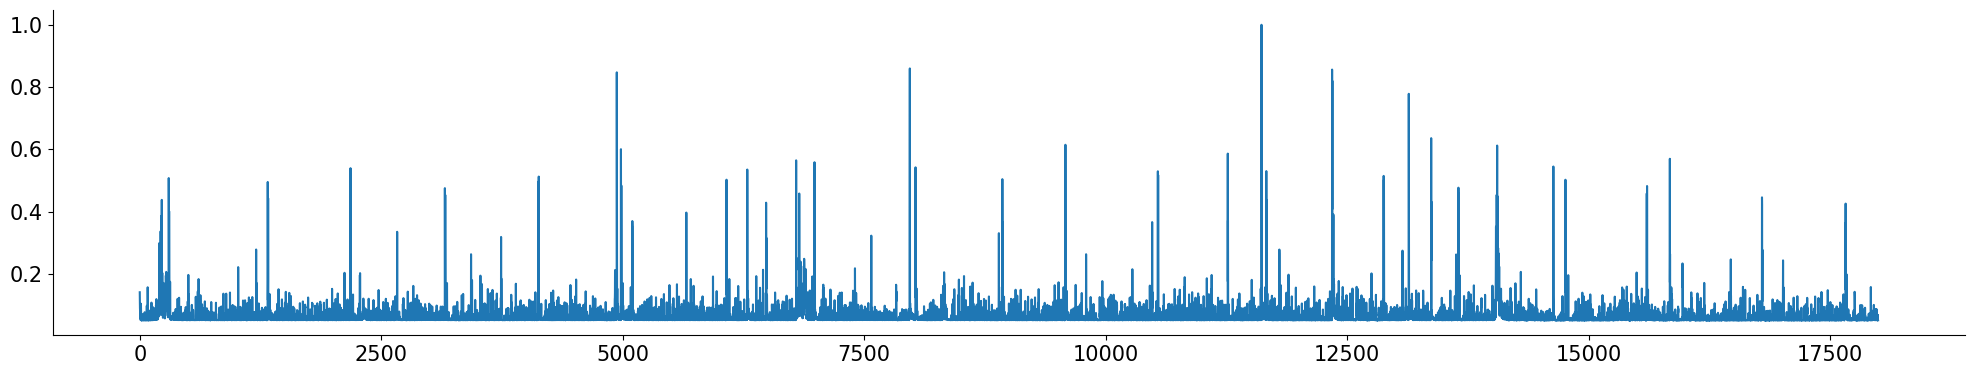

In [12]:
motion_energy_orig = compute_motion_energy(movie_path=movie_path, xrange=None, yrange=None, save_path=subject_path) #if first run, provide movie_path

# if len(motion_energy) != 3600:
#     motion_energy = pad(motion_energy)
#     motion_energy = average_frames(motion_energy, avg_block = 5) # avg as needed 

plt.plot(motion_energy_orig)
plt.show()

# Load SLEAP output (if computed)

In [13]:
#load sleap output

if is_sleap is True:
    files = os.listdir(subject_path)
    csv_files = [f for f in files if f.endswith('.csv')]
    
    # Check if there is exactly one CSV file
    if len(csv_files) == 1:
        # Load the CSV file into a DataFrame
        sleap_output_path = os.path.join(subject_path, csv_files[0])  # Get full path to the CSV file
        sleap_output = pd.read_csv(sleap_output_path)  # Pass the file path
        print(f"Loaded {csv_files[0]}")
    else:
        if len(csv_files) == 0:
            raise FileNotFoundError("No CSV files found")
        else:
            raise FileExistsError("Multiple CSV files found. Please ensure there is only one CSV file in the subject directory.")

# Average motion energy (from 15Hz to 3Hz - denoise)

In [14]:
def average_frames(data, avg_block=None):
    # Ensure data is a NumPy array
    if not isinstance(data, np.ndarray):
        data = np.asarray(data)

    # Check divisibility
    if len(data) % avg_block != 0:
        raise ValueError(f"Data length {len(data)} is not divisible by avg_block {avg_block}")

    # Reshape for 1D data
    if len(data.shape) == 1:  
        grouped = data.reshape(-1, avg_block)
    else:  # Reshape for 2D data
        grouped = data.reshape(-1, avg_block, data.shape[1])

    # Average across the `avg_block` dimension
    avg_data = np.mean(grouped, axis=1)
    print(f'Congrats again! Data is now {len(avg_data)}')
    return avg_data

In [15]:
motion_energy = pad(motion_energy_orig)
motion_energy = average_frames(motion_energy, avg_block = 5)

 Congrats! New shape is 18000
Congrats again! Data is now 3600


In [16]:
length_acts = len(motion_energy)
# for plotting xticks to seconds
frame_ticks = range(0, length_acts+ 100, 300)  # 300 frames is 100 sec
second_ticks = [int(tick/framerate) for tick in frame_ticks]   # Convert to seconds

In [17]:
second_ticks

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]

# Smooth motion energy

In [18]:
from scipy import stats 

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

# Compute SNR (signal to noise ratio) of motion energy & adjust smoothing 

In [19]:
snr = signaltonoise(motion_energy)
print(snr)

2.359730103256343


Adaptive window length: 37


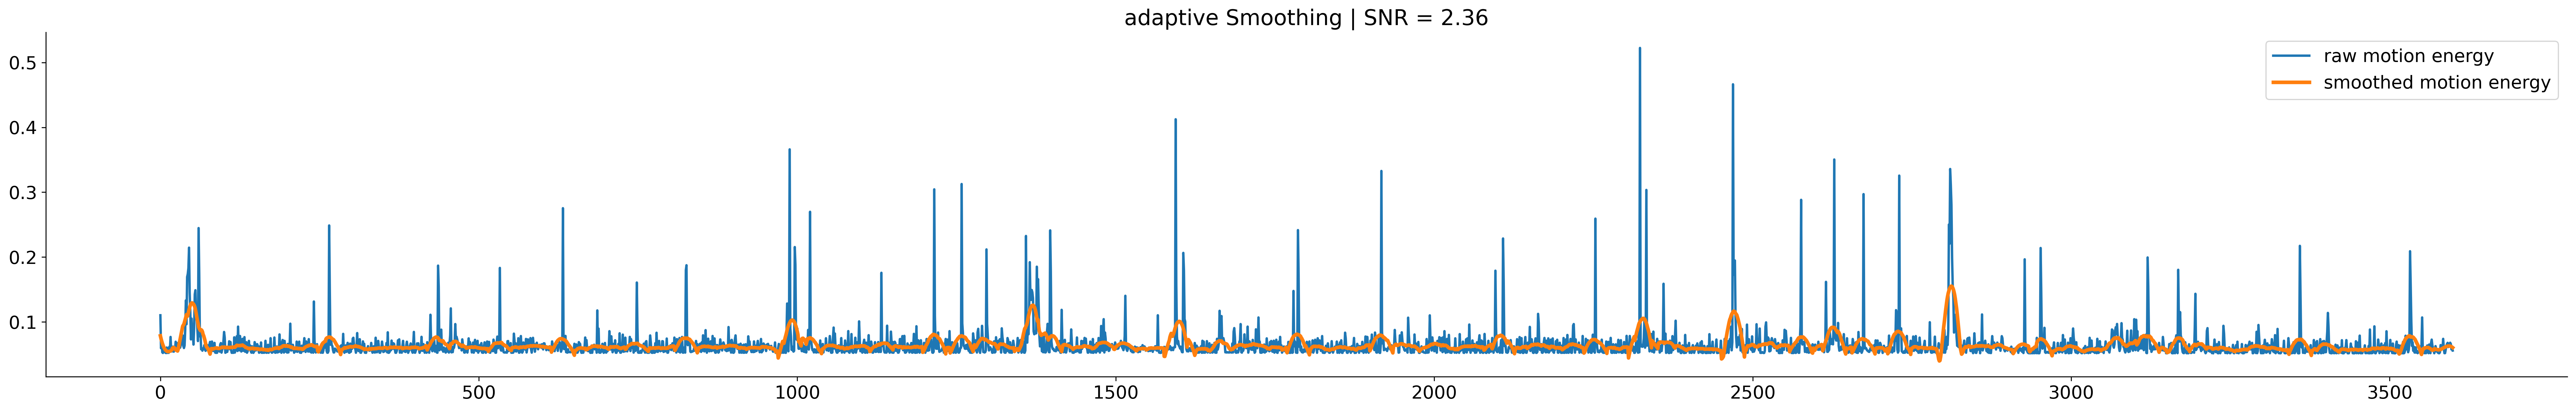

In [20]:
min_window_secs = 3  # minimal smoothing in seconds
max_window_secs = 15  # maximal smoothing in seconds here 

# Map SNR to window size: higher SNR -> shorter window
snr = np.clip(snr, 0.1, 10)  # avoid divide-by-zero or extremes
snr_norm = (10 - snr) / 9.9  # normalize to [0, 1]
adaptive_window_secs = min_window_secs + snr_norm * (max_window_secs - min_window_secs)
adaptive_window_length = int(adaptive_window_secs * framerate)

# Ensure odd and >= polyorder+2
polyorder = 3
if adaptive_window_length % 2 == 0:
    adaptive_window_length += 1
adaptive_window_length = max(adaptive_window_length, polyorder + 3)

print(f"Adaptive window length: {adaptive_window_length}")

# smooth 
smoothed_motion_energy = savgol_filter(motion_energy, window_length=adaptive_window_length,
                                       polyorder=polyorder, mode='interp')
# plot 
plt.figure(figsize=(30, 5), dpi=300)
plt.plot(motion_energy, label='raw motion energy', linewidth=2)
plt.plot(smoothed_motion_energy, label='smoothed motion energy', linewidth=3)
plt.legend()
plt.title(f"adaptive Smoothing | SNR = {snr:.2f}")
plt.tight_layout()
plt.show()

In [21]:
# for poly in [2, 3, 4]:
#     smoothed = savgol_filter(motion_energy, window_length=adaptive_window_length, polyorder=poly, mode='interp')
#     plt.plot(smoothed, label=f'Polyorder {poly}', linewidth=2)

# plt.plot(motion_energy, label='Raw', color='gray', alpha=0.4)
# plt.legend()
# plt.title(f"Comparison of Polynomial Orders | Window = {adaptive_window_length}")
# plt.tight_layout()
# plt.show()

# Choose statistical threshold for binarisation

Otsu should theoretically work if there is active-wake transition

In [22]:
def compute_thresholds_for_bin_state_detection(motion_signal, title='', save_dir=None, plot=True):
    '''
    Compute statistical thresholds to use for threshold-based state detection (active/awake - rest)
    Here we use: Otsu (prefer if binary distribution), Li (mutliple peak distribution), or mean+sd (gaussian distribution)
    '''
    
    # mean+sd threshold 
    motion_mean = np.mean(motion_signal)
    motion_sd = np.std(motion_signal)

    threshold_motion_mean_sd = motion_mean + motion_sd

    threshold_motion_li = filters.threshold_li(motion_signal)

    threshold_motion_otsu = filters.threshold_otsu(motion_signal)

    if plot:
        plt.figure(figsize=(5, 5), dpi=300)
        plt.title(f'{title}')
        plt.hist(motion_signal, bins=70, alpha=0.9)

        # mark threshold lines
        plt.axvline(x=threshold_motion_mean_sd, color='red', label='mean + sd', linestyle='--')
        plt.axvline(x=threshold_motion_otsu, color='salmon', label='Otsu', linestyle='--')
        plt.axvline(x=threshold_motion_li, color='darkred', label='Li', linestyle='--')

        plt.legend()
        plt.savefig(save_dir / f'{title}.png')
        plt.show()

    return threshold_motion_mean_sd, threshold_motion_li, threshold_motion_otsu

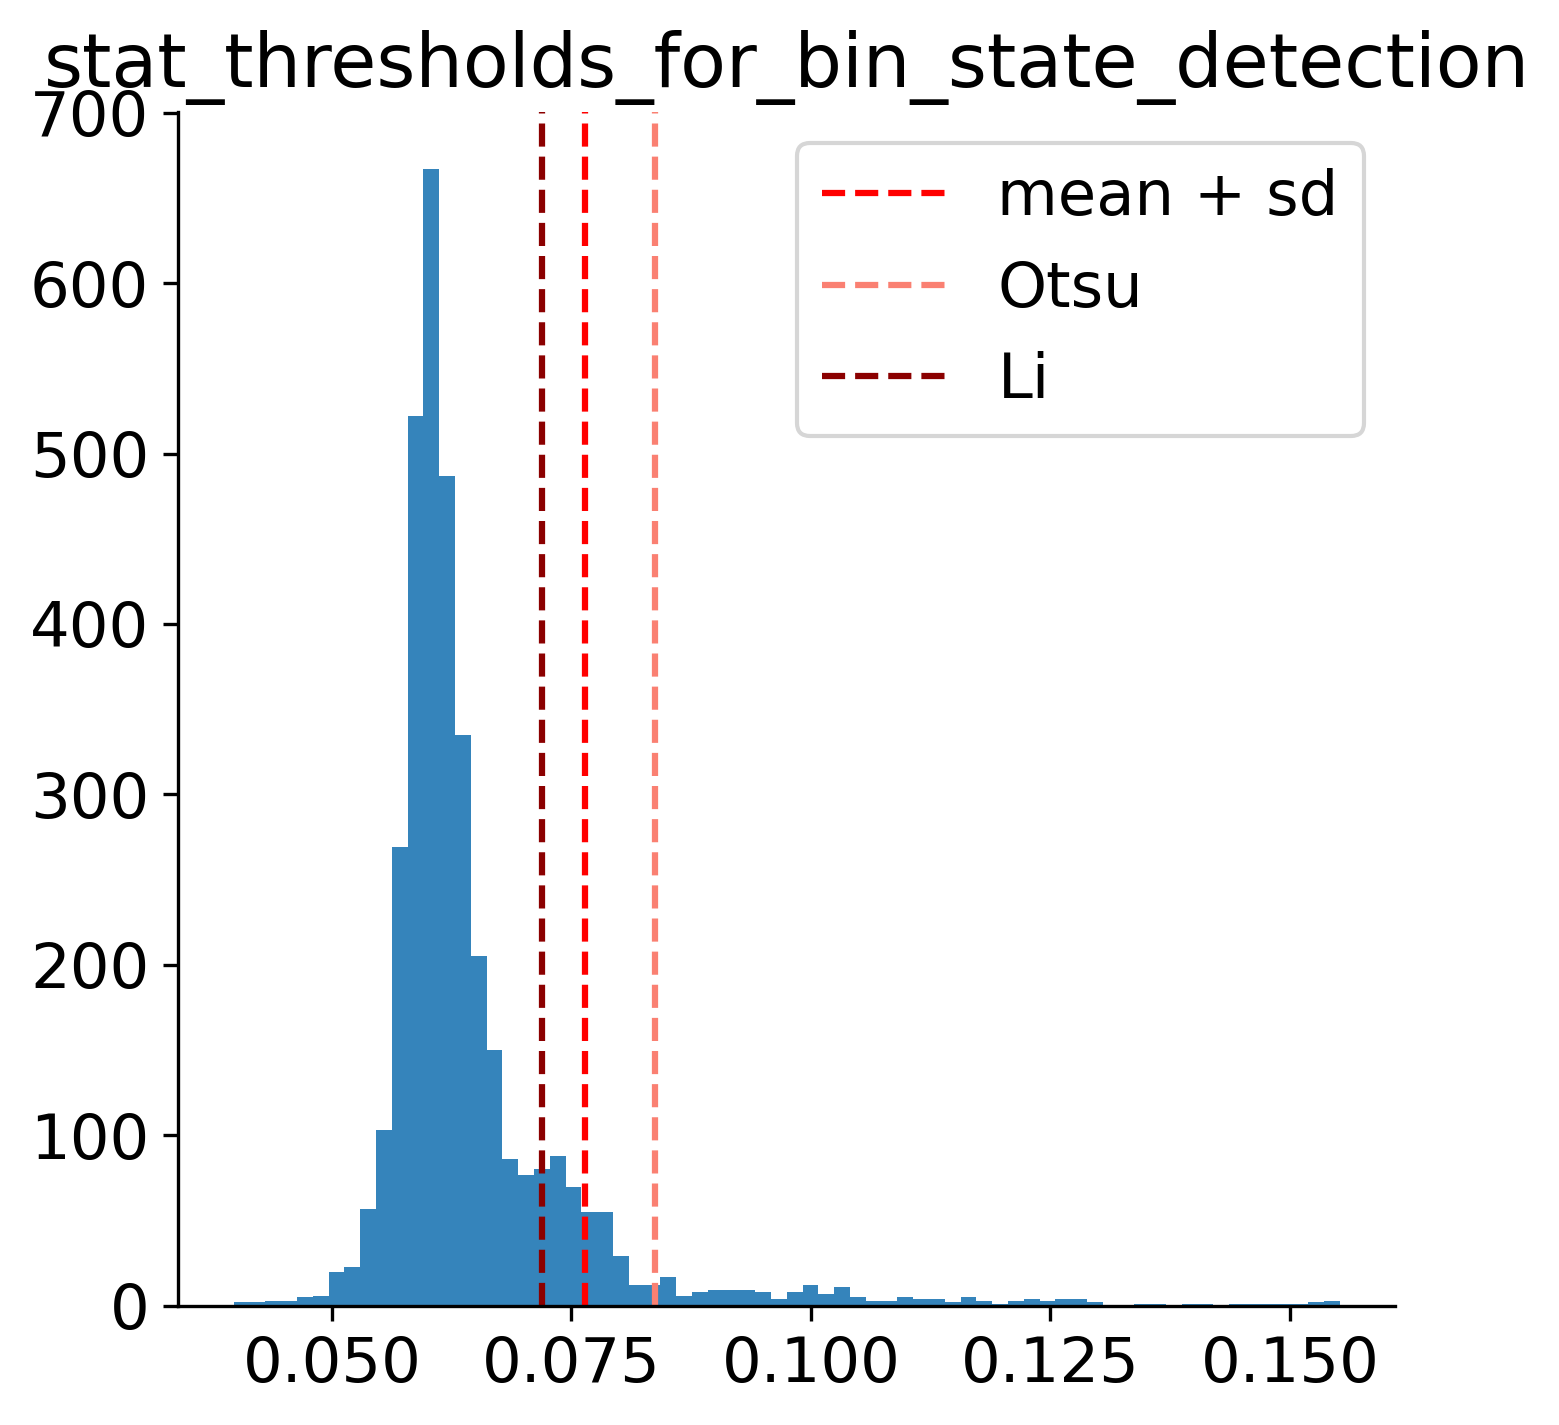

In [23]:
threshold_motion_mean_sd, threshold_motion_li, threshold_motion_otsu = compute_thresholds_for_bin_state_detection(smoothed_motion_energy, title='stat_thresholds_for_bin_state_detection', save_dir=save_dir_videography, plot=True)

# Choose binarisation threshold 

In [24]:
binary_threshold = threshold_motion_otsu #makes sense when we expect distribution to be bimodal 

# Binarise motion energy

In [25]:
def binarise_motion(motion_signal, binary_threshold, min_duration, min_inactive_gap=9):
    '''
    Binarises motion signal (eg mot_en) into 0s (rest) and 1s (active)
    input params:
    motion_signal: motion energy or other
    binary_threshold: sts threshold (li, otsu or mean_sd for state detection)
    min_di=uration: min_duration threshold to be detected as awake/active motion
    
    returns:
    bin_motion_signal: bin array of 0s and 1s 
    inds_active_state: indices of frames whens state is active
    inds_rest_state: indices of frames when state is rest/inactive 

    '''
    
    bin_motion_signal = np.zeros(len(motion_signal), dtype=int)

    # get boolean array 
    
    all_active_motions_detected = motion_signal > binary_threshold 

    # labels continuous segments that pass the threshold 

    labeled_array, n_features = label(all_active_motions_detected) #how many active motions where found 
    
    for i in range(1, n_features+1):
        segment = np.where(labeled_array == i)[0]
        if len(segment) > min_duration:
            bin_motion_signal[segment] = 1

    inds_active_state = np.where(bin_motion_signal ==1)
    inds_rest_state = np.where(bin_motion_signal ==0)
    
    return bin_motion_signal, inds_active_state, inds_rest_state

In [26]:
bin_motion_energy, inds_active_state, inds_rest_state =  binarise_motion(smoothed_motion_energy, binary_threshold=binary_threshold, min_duration=active_motion_duration_min, min_inactive_gap=9)

# Plot binary motion (Active - 1 / Rest - 0)

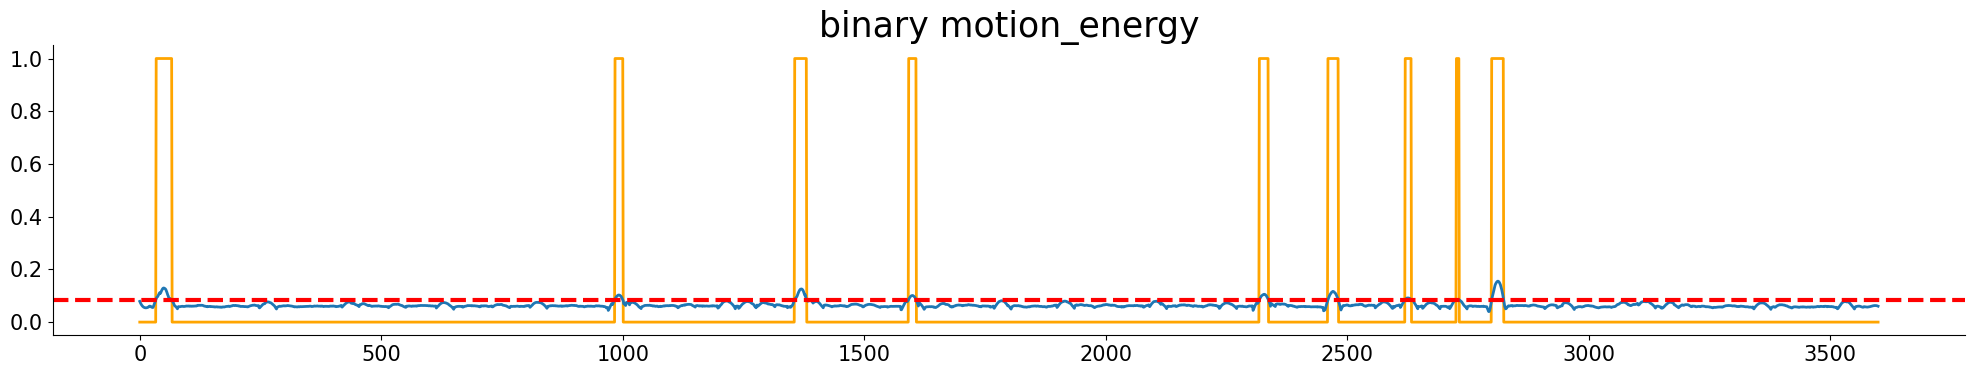

In [27]:
plt.plot(bin_motion_energy, color='orange', linewidth=2)
plt.plot(smoothed_motion_energy, linewidth=2)
plt.title('binary motion_energy', fontsize=25)
plt.axhline(y=threshold_motion_otsu, color='red', linestyle='--', label='binary threshold', linewidth=3)
# plt.savefig(save_dir_videography + 'thresholded_binarised_motion_energy.png')
plt.show()

In [28]:
from scipy.signal import find_peaks

In [29]:
# # Compute first derivative
# diff_motion = np.gradient(motion_energy)

# # Find peaks in the derivative where slope is steep
# peaks, _ = find_peaks(diff_motion, height=some_slope_threshold)

In [30]:
# from scipy.fft import fft
# power = np.abs(fft(motion_energy[0:3600])) 

# Define onsets and offsets of active motion 

In [31]:
active_motion_onsets = get_onsets(bin_motion_energy)
active_motion_offsets = get_offsets(bin_motion_energy)

# Classify Active (awake) motions to short / long and visualise them

In [32]:
def classify_active_motion_segments(bin_motion_signal, motion_signal, short_threshold, long_threshold):
    """
    Classify active/awake motion segments into short (1–3 sec), long (>3 sec), and too short (<1 sec, those are exluded in awake motion detection and set to 0).

    Parameters:
    - bin_motion_signal: 1D array of HMM or thresholded motion states (1 for active, 0 for inactive)
    - motion_signal: 1D array of motion energy values
    - short_threshold: in frames, minimum duration for short active motions (e.g., 3 or 1s at 3Hz)
    - long_threshold: in frames, minimum duration for long active motions (e.g., 9 or 3s at 3Hz)

    Returns:
    - bin_short_active_motion: binary array marking short motions (1-3s)
    - bin_long_active_motion: binary array marking long motions (>3s)
    - bin_too_short_active_motion: binary array marking short blips (<1s)
    - and correspondings inds of long, short or too short (excluded) motions
    """
    labeled_array, num_features = label(bin_motion_signal == 1)

    bin_short_active_motion = np.zeros(len(motion_signal), dtype=int)
    bin_long_active_motion = np.zeros(len(motion_signal), dtype=int)
    bin_too_short_active_motion = np.zeros(len(motion_signal), dtype=int)

    for i in range(1, num_features + 1):
        segment = np.where(labeled_array == i)[0]

        if len(segment) > long_threshold:
            bin_long_active_motion[segment] = 1
        elif len(segment) > short_threshold:
            bin_short_active_motion[segment] = 1
        elif len(segment) > 0: # but shorter than short threshold 
            bin_too_short_active_motion[segment] = 0 # mark as inactive 

        long_active_motion_inds = np.where(bin_long_active_motion==1)[0]
        short_active_motion_inds = np.where(bin_short_active_motion==1)[0]
        too_short_active_motion_inds = np.where(bin_too_short_active_motion==1)[0]

            
    return bin_short_active_motion, short_active_motion_inds, bin_long_active_motion, long_active_motion_inds, bin_too_short_active_motion, too_short_active_motion_inds

Saved plot to: D:\Users\Max\Documents\data_proc\sz\cells\sz089\2024-06-07_a\motion_annotation_average\subplots_bin_motion_energy_classified.png


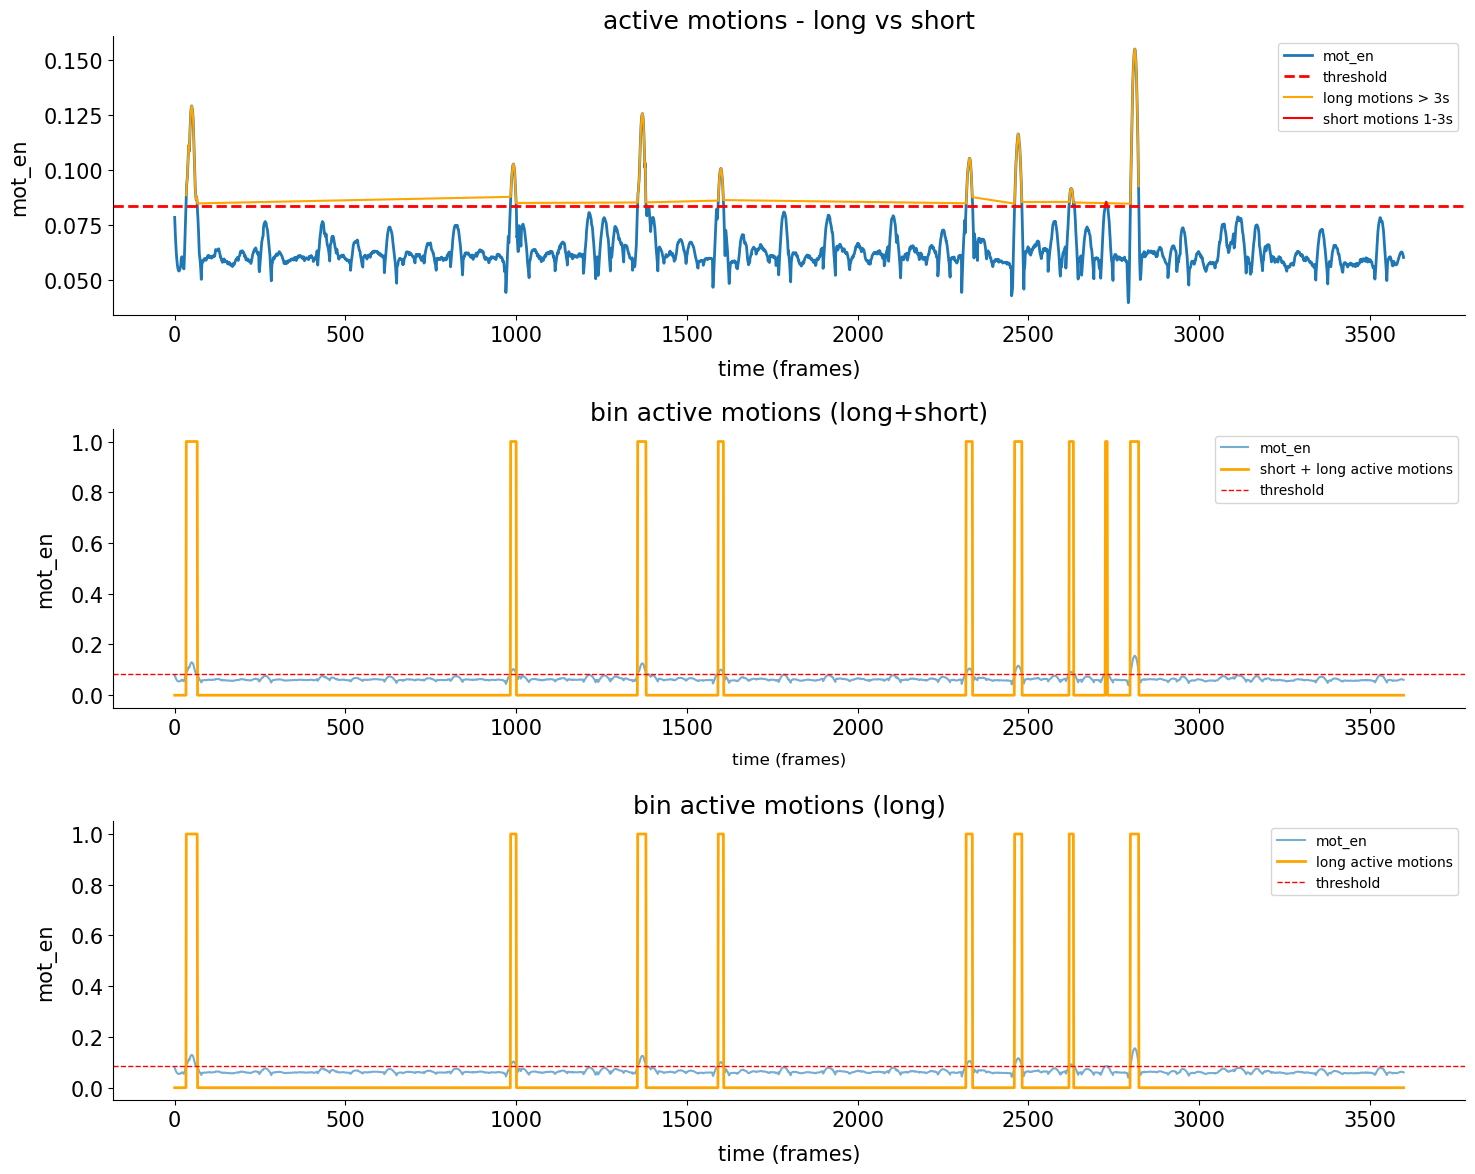

In [33]:
# classify active motions detected 
bin_short_active_motion, short_active_motion_inds, bin_long_active_motion, long_active_motion_inds, bin_too_short_active_motion, too_short_active_motion_inds = classify_active_motion_segments(
    bin_motion_energy,
    motion_energy,
    short_threshold=active_motion_duration_min,
    long_threshold=long_active_motion_duration_min
)

# plot classified active motions detected 
plot_active_motion_classification_subplots(
    motion_signal=motion_energy,
    smoothed_motion_signal=smoothed_motion_energy,
    bin_motion_energy=bin_motion_energy,
    bin_long_active_motion=bin_long_active_motion,
    bin_short_active_motion=bin_short_active_motion,
    long_active_motion_inds=long_active_motion_inds,
    short_active_motion_inds=short_active_motion_inds,
    threshold=threshold_motion_otsu,
    save_path=save_dir_videography / 'subplots_bin_motion_energy_classified.png',
)

In [34]:
# turn indices into continuous segments eg 25-100 is active seg 1, 500-805 active seg 2 etc
active_segments = get_active_segments(inds_active_state[0]) #all not only long
long_active_segments = get_active_segments(long_active_motion_inds) #all not only long , already numpy
# if len(short_active_segments)>1: #to solve not defined
    # short_active_segments = get_active_segments(short_active_motion_inds)

# Twitch detection 

TODO: maybe low pass filter rest periods to remove noises 

In [35]:
rest_period = motion_energy[inds_rest_state] #identify periods of low motion energy ==0 (non smoothed (!))
rest_period = rest_period.flatten()

In [36]:
log_signal = np.log1p(rest_period)  # log1p avoids issues with zeroes
threshold_log= np.percentile(rest_period, 95)

In [37]:
from statsmodels.robust import mad

def compute_thresholds_for_bin_state_detection(motion_signal, save_dir=None, plot=True):
    '''
    Compute statistical thresholds to use for threshold-based state detection (active/awake - rest)
    Here we use: Otsu (prefer if binary distribution), Li (mutliple peak distribution), or mean+sd (gaussian distribution)
    '''
    
    # mean+sd threshold 
    motion_mean = np.mean(motion_signal)
    motion_sd = np.std(motion_signal)

    threshold_motion_mean_sd = motion_mean + 3*motion_sd

    threshold_motion_li = filters.threshold_li(motion_signal)

    threshold_motion_otsu = filters.threshold_otsu(motion_signal)

    threshold_95 = np.percentile(motion_signal, 95) 

    # log_signal = np.log1p(motion_signal)  # log1p avoids issues with zeroes
    # threshold_log= np.percentile(motion_signal, 95)

    med = np.median(motion_signal)
    mad_val = mad(motion_signal)
    threshold_mad = med + 3 * mad_val  # 3x MAD is analogous to ~3σ in normal data

    if plot:
        plt.figure(figsize=(5, 5), dpi=300)
        plt.title('stat thresholds on mot_en')
        plt.hist(motion_signal, bins=70, alpha=0.9)

        # mark threshold lines
        plt.axvline(x=threshold_motion_mean_sd, color='red', label='mean + sd', linestyle='--')
        plt.axvline(x=threshold_motion_otsu, color='salmon', label='Otsu', linestyle='--')
        plt.axvline(x=threshold_motion_li, color='darkred', label='Li', linestyle='--')
        # plt.axvline(x=threshold_log, color='pink', label='95 threshold on log_motion')
        plt.axvline(x=threshold_mad, color='pink', label='threshold mad', linestyle='--')
        plt.axvline(x=threshold_95, color='purple', label='threshold 95%', linestyle='--')


        plt.legend()
        plt.savefig(save_dir / 'binary_state_thresholds.png')
        plt.show()

    return threshold_motion_mean_sd, threshold_motion_li, threshold_motion_otsu, threshold_mad, threshold_95

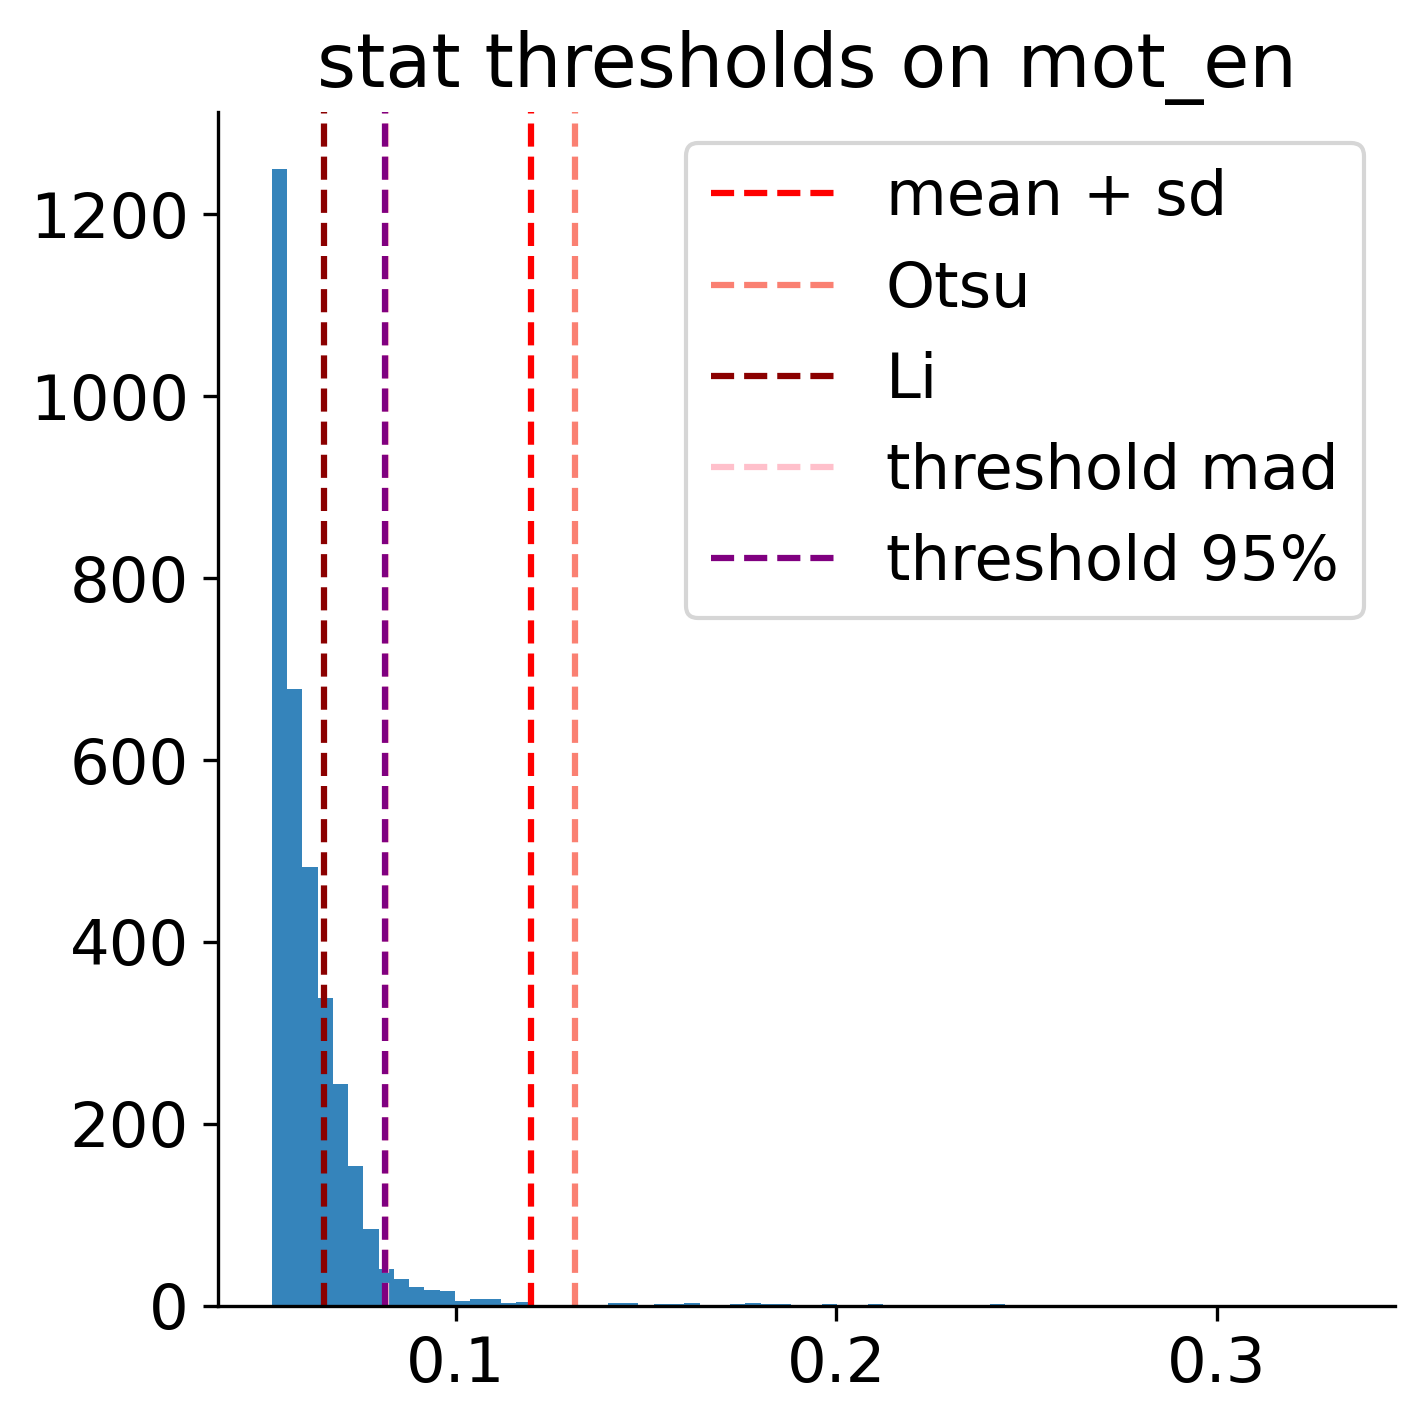

In [38]:
twitch_threshold_motion_mean_sd, twitch_threshold_motion_li, twitch_threshold_motion_otsu, threshold_mad, threshold_95 = compute_thresholds_for_bin_state_detection(rest_period, save_dir=save_dir_videography, plot=True)

# Choose twitch threshold 

In [39]:
# choose a threshold 
# twitch_threshold = twitch_threshold_li #more permissive of twitches --> more twitches detected (pre-filtering)

twitch_threshold = twitch_threshold_motion_li # IMPORTANT 

In [40]:
inds_twitches_unfiltered = np.where(rest_period > twitch_threshold) #inds of prospective twitches (in array of low motion energy) careful its on the size of low motion array
inds_twitches_unfiltered = inds_rest_state[0][inds_twitches_unfiltered] 

In [41]:
unfiltered_putative_twitches_segments = find_sequential_groups(inds_twitches_unfiltered)
len(unfiltered_putative_twitches_segments)

586

In [42]:
def binarise_twitch(motion_energy, twitch_segments):

    # Initialize bin_twitch   
    bin_twitch = np.zeros(len(motion_energy))

    # flatten the nested list
    flat_inds = [idx for segment in twitch_segments for idx in segment] # filtered corrected twitch segments 

    print("Flattened Indices:", flat_inds)

    # Assign 1 to twitch inds
    for idx in flat_inds:
        if idx < len(motion_energy):  # Ensure index is within bounds
            bin_twitch[idx] = 1
            print(f"Assigning 1 at column {idx}")
        else:
            print(f"Skipping out-of-bounds index: {idx}")
    return bin_twitch

In [43]:
bin_putative_twitch = binarise_twitch(motion_energy, unfiltered_putative_twitches_segments) #segs 

Flattened Indices: [0, 2, 16, 24, 26, 33, 78, 81, 85, 95, 99, 100, 101, 108, 110, 116, 120, 122, 125, 126, 129, 132, 135, 139, 148, 152, 158, 165, 173, 179, 187, 191, 192, 193, 195, 200, 202, 204, 214, 218, 226, 229, 233, 241, 242, 246, 253, 257, 260, 265, 266, 268, 287, 294, 298, 302, 303, 309, 313, 318, 320, 331, 338, 342, 348, 355, 357, 363, 366, 367, 373, 374, 375, 381, 387, 393, 397, 398, 403, 405, 410, 413, 419, 423, 424, 425, 429, 430, 436, 437, 440, 441, 452, 454, 455, 456, 462, 463, 464, 465, 466, 467, 470, 474, 484, 486, 491, 494, 498, 504, 509, 513, 516, 523, 524, 528, 529, 531, 532, 533, 537, 545, 546, 550, 555, 556, 558, 562, 566, 570, 574, 577, 581, 585, 587, 591, 599, 602, 603, 615, 627, 632, 635, 636, 650, 657, 658, 659, 667, 669, 686, 688, 694, 698, 705, 708, 711, 714, 719, 721, 726, 730, 737, 739, 742, 745, 748, 749, 759, 762, 763, 769, 770, 777, 779, 783, 788, 789, 795, 804, 807, 808, 809, 811, 812, 815, 819, 825, 826, 827, 829, 830, 831, 841, 843, 847, 848, 850, 852

# Filter twitches 


### Based on proximity to wake motions 

In [44]:
def filter_twitches_by_awake_proximity(inds_twitches, inds_active_state, min_distance=None):
    filtered_twitches = []

    for idx_twitch in inds_twitches:
        distance = np.abs(inds_active_state - idx_twitch)
        if np.min(distance) > min_distance:
            filtered_twitches.append(idx_twitch)

    filtered_twitches = np.array(filtered_twitches)

    return filtered_twitches

In [45]:
twitch_min_distance_from_active

9

In [46]:
inds_twitches_filtered_step1 = filter_twitches_by_awake_proximity(inds_twitches_unfiltered, inds_active_state, min_distance=twitch_min_distance_from_active) 

In [47]:
len(inds_twitches_filtered_step1)

807

### Based on duration 

In [48]:
inds_twitches_segments = find_sequential_groups(inds_twitches_filtered_step1)
active_motion_segments = find_sequential_groups(inds_active_state[0])
resting_motion_segments = find_sequential_groups(inds_rest_state[0])

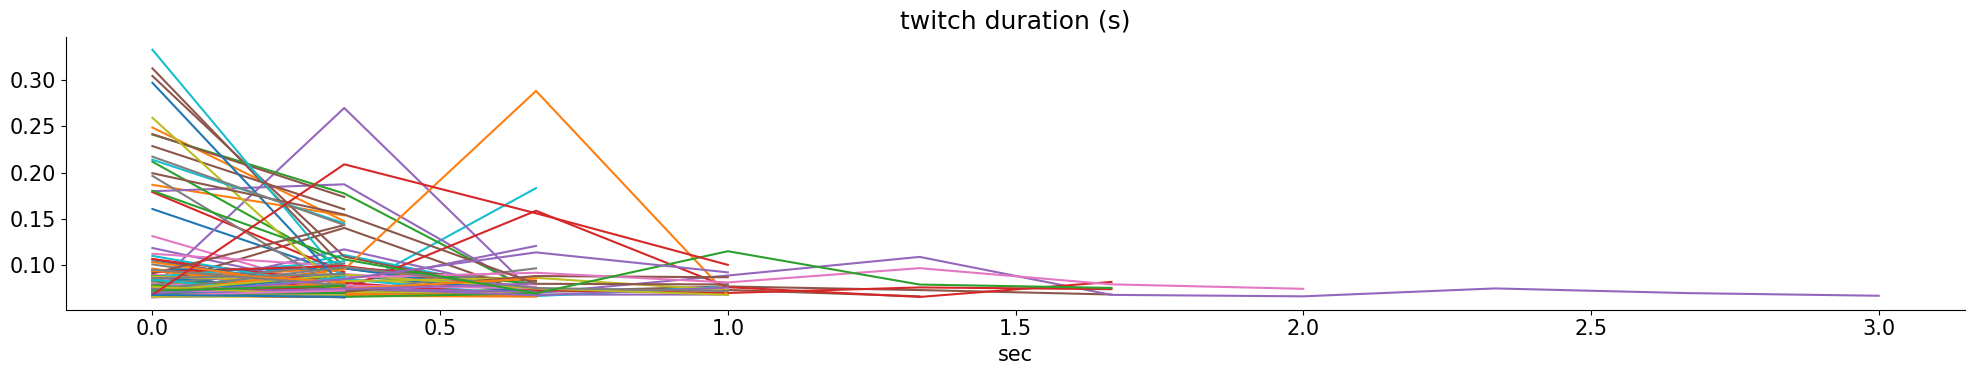

In [49]:
for seg in inds_twitches_segments:

    time = np.arange(len(seg))/framerate
    plt.plot(time, motion_energy[seg])
    plt.title('twitch duration (s)')
    plt.xlabel('sec')
plt.savefig(save_dir_videography / 'twitch_duration_non_filtered.png')

In [50]:
twitch_duration_max #frames 

3

In [51]:
# filter twitches based on duration 
def filter_segments_by_duration(segments, duration_threshold):
# Filter out groups based on the duration threshold
    return [twitches for twitches in segments if len(twitches) <= duration_threshold]

In [52]:
# get filtered twitches 
inds_twitches_filtered_step2 = filter_segments_by_duration(inds_twitches_segments, twitch_duration_max)

In [53]:
twitch_duration_max

3

In [54]:
len(inds_twitches_filtered_step2)

543

# Binarise twitch 

In [55]:
def binarise_twitch(motion_energy, twitch_segments):

    # Initialize bin_twitch   
    bin_twitch = np.zeros(len(motion_energy))

    # flatten the nested list
    flat_inds = [idx for segment in twitch_segments for idx in segment] # filtered corrected twitches 

    print("Flattened Indices:", flat_inds)

    # Assign 1 to twitch inds
    for idx in flat_inds:
        if idx < len(motion_energy):  # Ensure index is within bounds
            bin_twitch[idx] = 1
            print(f"Assigning 1 at column {idx}")
        else:
            print(f"Skipping out-of-bounds index: {idx}")
    return bin_twitch

In [56]:
bin_twitch_unfilt = binarise_twitch(motion_energy, inds_twitches_filtered_step2)

Flattened Indices: [0, 2, 16, 24, 78, 81, 85, 95, 99, 100, 101, 108, 110, 116, 120, 122, 125, 126, 129, 132, 135, 139, 148, 152, 158, 165, 173, 179, 187, 191, 192, 193, 195, 200, 202, 204, 214, 218, 226, 229, 233, 241, 242, 246, 253, 257, 260, 265, 266, 268, 287, 294, 298, 302, 303, 309, 313, 318, 320, 331, 338, 342, 348, 355, 357, 363, 366, 367, 373, 374, 375, 381, 387, 393, 397, 398, 403, 405, 410, 413, 419, 423, 424, 425, 429, 430, 436, 437, 440, 441, 452, 454, 455, 456, 470, 474, 484, 486, 491, 494, 498, 504, 509, 513, 516, 523, 524, 528, 529, 531, 532, 533, 537, 545, 546, 550, 555, 556, 558, 562, 566, 570, 574, 577, 581, 585, 587, 591, 599, 602, 603, 615, 627, 632, 635, 636, 650, 657, 658, 659, 667, 669, 686, 688, 694, 698, 705, 708, 711, 714, 719, 721, 726, 730, 737, 739, 742, 745, 748, 749, 759, 762, 763, 769, 770, 777, 779, 783, 788, 789, 795, 804, 807, 808, 809, 811, 812, 815, 819, 825, 826, 827, 829, 830, 831, 841, 843, 847, 848, 850, 852, 856, 860, 864, 867, 870, 879, 880, 8


# Define onset and offset of twitch

In [57]:
active_onsets = get_onsets(bin_motion_energy)
active_offsets = get_offsets(bin_motion_energy)
twitch_onsets = get_onsets(bin_twitch_unfilt)
twitch_offsets = get_offsets(bin_twitch_unfilt)

# Plot interval between twitches (if burst - remove ?)

In [58]:
# iti.min() #/framerate # 2*1/framerate = 0.66*2= 0.13 (133 ms)

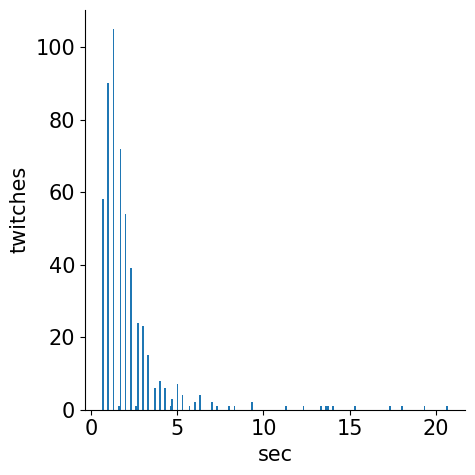

In [59]:
iti = np.diff(twitch_onsets/framerate)

plt.figure(figsize=(5,5))
plt.hist(iti.flatten(), bins=200)
plt.xlabel('sec')
plt.ylabel('twitches')
plt.show()

# most twithces occur in burst fashion 

# Filter twitches based on inter-twitch-interval

(aka discard bursts, keep sparse 'trusted' twitches)

In [60]:
inds_twitches_filtered_final = filter_bursty_twitches(inds_twitches_filtered_step2, min_frame_gap=1) # 1 frame is ~330 ms

In [61]:
print(inds_twitches_filtered_final)

[[0], [2], [16], [24], [78], [81], [85], [95], [99, 100, 101], [108], [110], [116], [120], [122], [125, 126], [129], [132], [135], [139], [148], [152], [158], [165], [173], [179], [187], [191, 192, 193], [195], [200], [202], [204], [214], [218], [226], [229], [233], [241, 242], [246], [253], [257], [260], [265, 266], [268], [287], [294], [298], [302, 303], [309], [313], [318], [320], [331], [338], [342], [348], [355], [357], [363], [366, 367], [373, 374, 375], [381], [387], [393], [397, 398], [403], [405], [410], [413], [419], [423, 424, 425], [429, 430], [436, 437], [440, 441], [452], [454, 455, 456], [470], [474], [484], [486], [491], [494], [498], [504], [509], [513], [516], [523, 524], [528, 529], [531, 532, 533], [537], [545, 546], [550], [555, 556], [558], [562], [566], [570], [574], [577], [581], [585], [587], [591], [599], [602, 603], [615], [627], [632], [635, 636], [650], [657, 658, 659], [667], [669], [686], [688], [694], [698], [705], [708], [711], [714], [719], [721], [726

In [62]:
len(inds_twitches_filtered_final)

543

# Final binary twitch signal -after all filters-

In [63]:
bin_twitch = binarise_twitch(motion_energy, inds_twitches_filtered_final) #expects class segments

Flattened Indices: [0, 2, 16, 24, 78, 81, 85, 95, 99, 100, 101, 108, 110, 116, 120, 122, 125, 126, 129, 132, 135, 139, 148, 152, 158, 165, 173, 179, 187, 191, 192, 193, 195, 200, 202, 204, 214, 218, 226, 229, 233, 241, 242, 246, 253, 257, 260, 265, 266, 268, 287, 294, 298, 302, 303, 309, 313, 318, 320, 331, 338, 342, 348, 355, 357, 363, 366, 367, 373, 374, 375, 381, 387, 393, 397, 398, 403, 405, 410, 413, 419, 423, 424, 425, 429, 430, 436, 437, 440, 441, 452, 454, 455, 456, 470, 474, 484, 486, 491, 494, 498, 504, 509, 513, 516, 523, 524, 528, 529, 531, 532, 533, 537, 545, 546, 550, 555, 556, 558, 562, 566, 570, 574, 577, 581, 585, 587, 591, 599, 602, 603, 615, 627, 632, 635, 636, 650, 657, 658, 659, 667, 669, 686, 688, 694, 698, 705, 708, 711, 714, 719, 721, 726, 730, 737, 739, 742, 745, 748, 749, 759, 762, 763, 769, 770, 777, 779, 783, 788, 789, 795, 804, 807, 808, 809, 811, 812, 815, 819, 825, 826, 827, 829, 830, 831, 841, 843, 847, 848, 850, 852, 856, 860, 864, 867, 870, 879, 880, 8

# Get final onsets (post sparsness filtering)

In [64]:
twitch_onsets = get_onsets(bin_twitch)
twitch_offsets = get_offsets(bin_twitch)

# Plot twitches detected before and after sparse filtering 

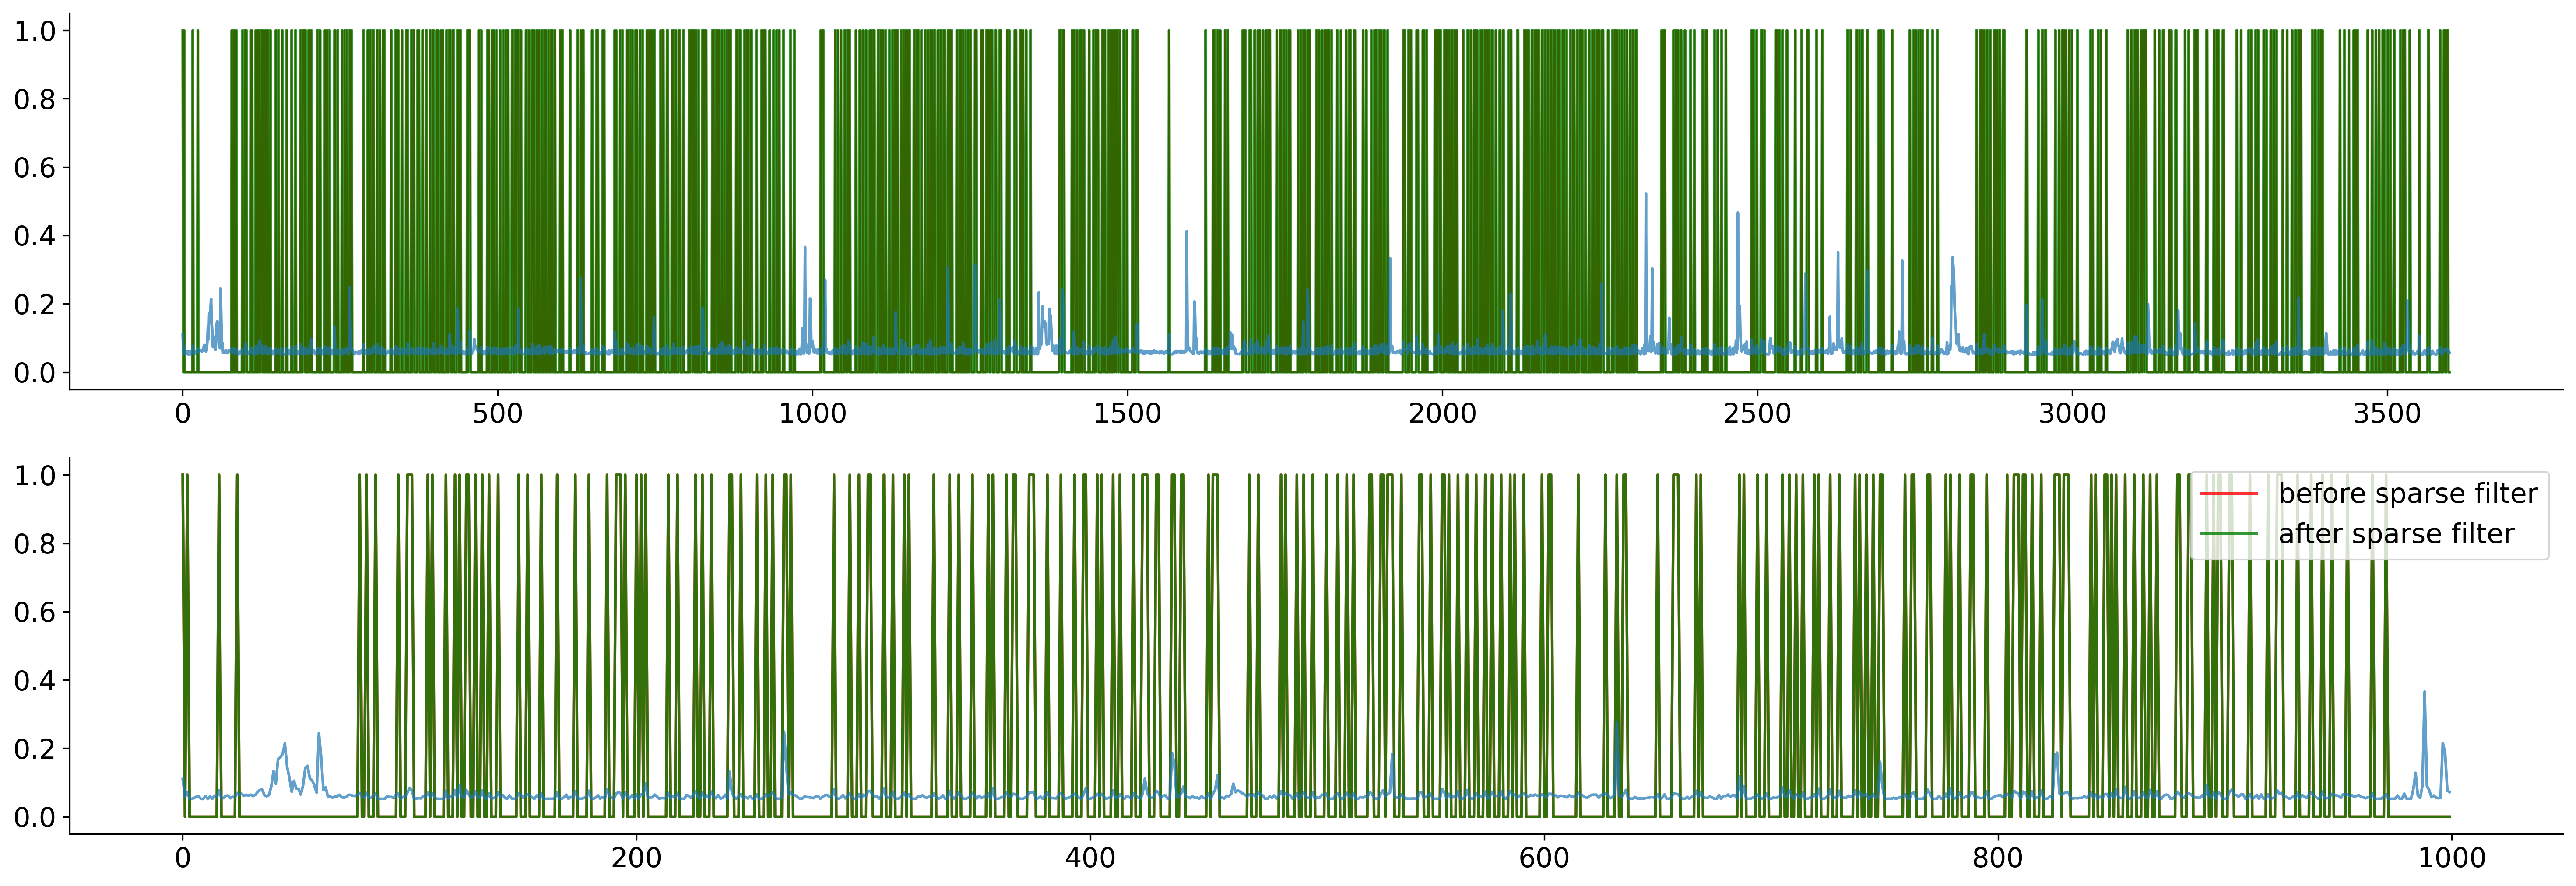

In [65]:
fig, axs = plt.subplots(2,1, figsize=(20,7), dpi=300)
axs[0].plot(bin_twitch_unfilt, linewidth=0.8, c='red')
axs[0].plot(bin_twitch, alpha=0.8, c='green')
axs[0].plot(motion_energy, alpha=0.7)

axs[1].plot(bin_twitch_unfilt[:1000],c='red', alpha=0.8, label='before sparse filter')
axs[1].plot(bin_twitch[:1000], alpha=0.8, c='green', label = 'after sparse filter')
axs[1].plot(motion_energy[:1000], alpha=0.7)
plt.legend(loc = 'upper right')
plt.show()

In [66]:
(np.where(bin_twitch[:]==1))

(array([   0,    2,   16,   24,   78,   81,   85,   95,   99,  100,  101,
         108,  110,  116,  120,  122,  125,  126,  129,  132,  135,  139,
         148,  152,  158,  165,  173,  179,  187,  191,  192,  193,  195,
         200,  202,  204,  214,  218,  226,  229,  233,  241,  242,  246,
         253,  257,  260,  265,  266,  268,  287,  294,  298,  302,  303,
         309,  313,  318,  320,  331,  338,  342,  348,  355,  357,  363,
         366,  367,  373,  374,  375,  381,  387,  393,  397,  398,  403,
         405,  410,  413,  419,  423,  424,  425,  429,  430,  436,  437,
         440,  441,  452,  454,  455,  456,  470,  474,  484,  486,  491,
         494,  498,  504,  509,  513,  516,  523,  524,  528,  529,  531,
         532,  533,  537,  545,  546,  550,  555,  556,  558,  562,  566,
         570,  574,  577,  581,  585,  587,  591,  599,  602,  603,  615,
         627,  632,  635,  636,  650,  657,  658,  659,  667,  669,  686,
         688,  694,  698,  705,  708, 

# Plot filtered twitches detected on motion energy

In [67]:
def plot_detected_twitches(
    motion_energy,
    smoothed_motion_energy,
    bin_motion_energy,
    threshold_twitches,
    threshold_motion_energy,
    inds_twitches,
    frame_ticks,
    second_ticks,
    save_dir=None
):
    """
    Plot the motion energy and smoothed motion energy with twitch detection.

    Parameters:
    - motion_energy: Raw motion energy signal.
    - smoothed_motion_energy: Smoothed motion energy signal.
    - threshold_twitches: Threshold for twitch detection.
    - threshold_motion_energy: Threshold for binary motion energy.
    - inds_twitches: Indices where twitch segments start (onsets).
    - frame_ticks: Frame indices for x-axis.
    - second_ticks: Time ticks in seconds for x-axis.
    - save_dir_videography: Optional directory to save the figure.
    """
    
    fig, axs = plt.subplots(2, 1, figsize=(15, 7), dpi=300)

    # Plot raw and smoothed motion energy
    axs[0].plot(motion_energy, color='orange', linewidth=2, label='mot_en')
    axs[0].plot(smoothed_motion_energy, color='blue', linewidth=1.5, label='mot_en smoothed')
    axs[0].axhline(y=threshold_twitches, color='red', linestyle='--', label='Twitch threshold')
    axs[0].set_xticks(ticks=frame_ticks)
    axs[0].set_xticklabels(second_ticks, fontsize=12)
    axs[0].legend(loc='upper right', fontsize=10)
    axs[0].set_ylabel('mot_en', fontsize=15)
    axs[0].set_title('Twitch detection', fontsize=18)

    trio_motion_energy = bin_motion_energy.copy()
    trio_motion_energy[inds_twitches] = -1  # mark twitch segments with -1

    # Plot raw motion energy and binary motion energy (including twitch detection)
    axs[1].plot(motion_energy, color='blue', linewidth=1, label='mot_en')
    axs[1].plot(trio_motion_energy, color='darkorange', linewidth=1, label='3 states on mot_en')
    axs[1].axhline(y=threshold_twitches, color='red', linestyle='--', label='twitch threshold')
    axs[1].set_xticks(ticks=frame_ticks)
    axs[1].set_xticklabels(second_ticks, fontsize=12)
    axs[1].set_xlabel('Time (s)', fontsize=15)
    # axs[1].set_title('Twitch detection', fontsize=18)

    # Adjust layout and save the plot
    plt.subplots_adjust(hspace=0.6)

    if save_dir_videography:
        plt.savefig(save_dir / 'trio_motion_energy_including_twitches.png')
        print(f"Plot saved to: {save_dir / 'trio_motion_energy_including_twitches.png'}")

    plt.show()

In [68]:
len(twitch_onsets)

543

Plot saved to: D:\Users\Max\Documents\data_proc\sz\cells\sz089\2024-06-07_a\motion_annotation_average\trio_motion_energy_including_twitches.png


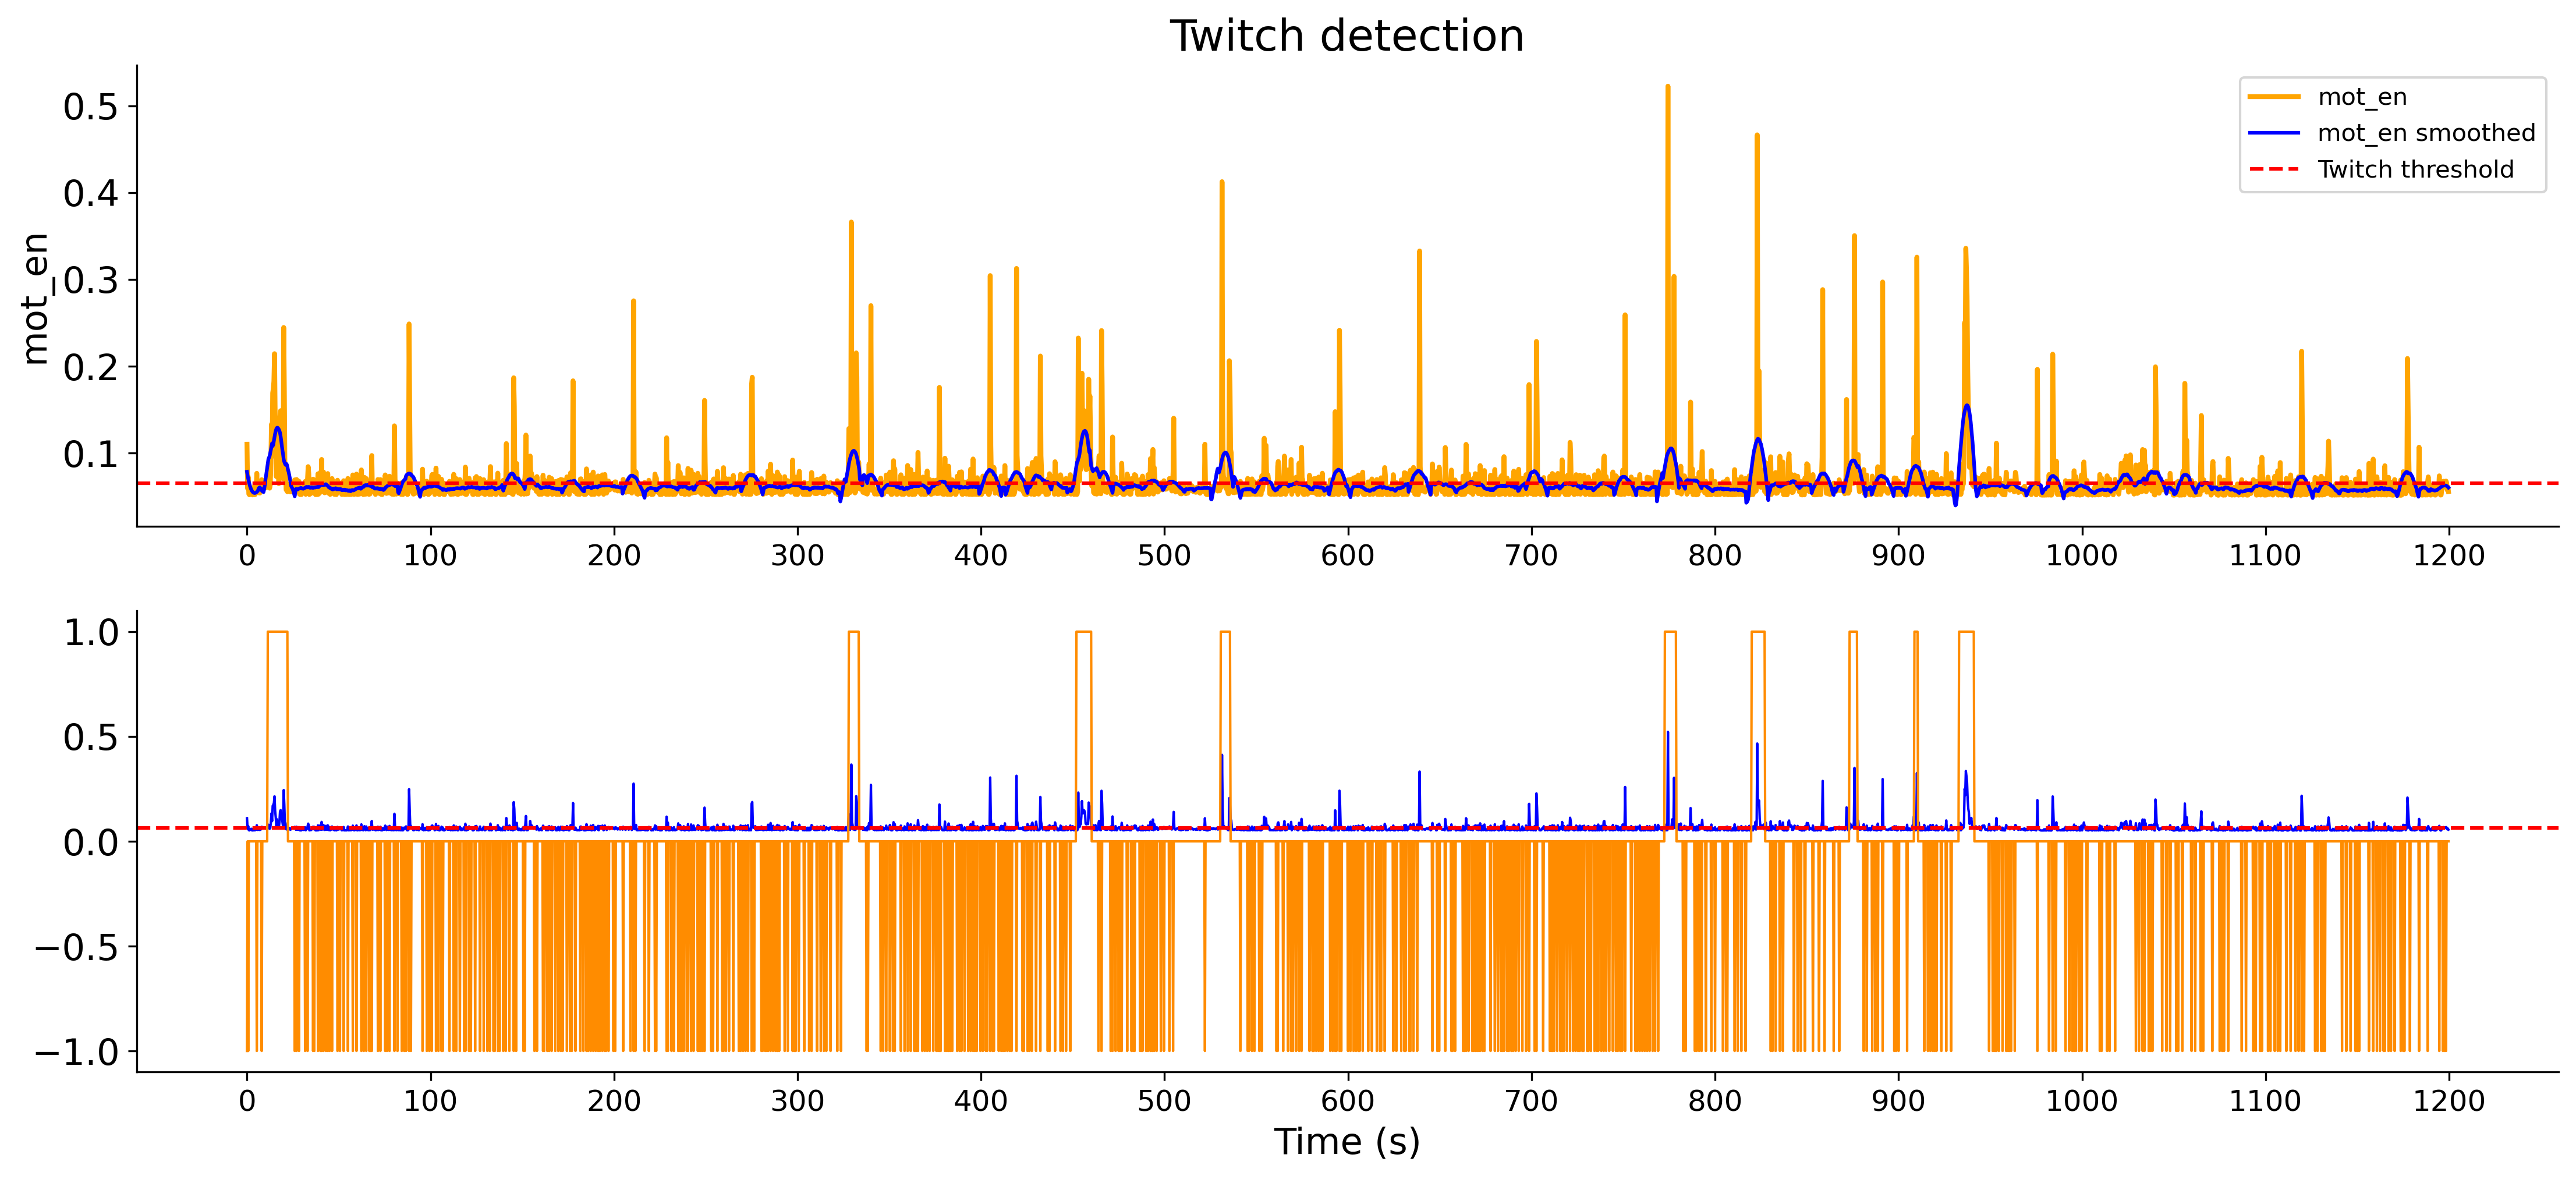

In [69]:
plot_detected_twitches(
    motion_energy=motion_energy,
    smoothed_motion_energy=smoothed_motion_energy,
    bin_motion_energy=bin_motion_energy,
    threshold_twitches=twitch_threshold,
    threshold_motion_energy= binary_threshold,
    inds_twitches=twitch_onsets,
    frame_ticks=frame_ticks,
    second_ticks=second_ticks,
    save_dir=save_dir_videography
)

In [70]:
n_twitches = len(twitch_onsets) 
n_active_motions = len(active_motion_segments)

In [71]:
# ========== SUMMARY ==========
print(f"Total active/awake motions detected: {n_active_motions}")
print(f"Total twitches detected: {n_twitches}")

Total active/awake motions detected: 9
Total twitches detected: 543


# Final annotated motion 

In [72]:
def get_behavior_classification(bin_putative_twitch, bin_twitch, bin_motion_energy, active_onsets, twitch_onsets):
    """
    Classify behavior states and key motion onsets.

    Parameters:
        bin_putative_twitch (np.ndarray): raw unfiltered twitch binary array
        bin_twitch (np.ndarray): filtered twitch binary array
        bin_motion_energy (np.ndarray): binarized motion energy (1 = active, 0 = rest)

    Returns:
        dict: classified behavior array and key motion index groups
    """
    classified_behavior = bin_motion_energy.copy()
    classified_behavior[twitch_onsets] = -1
    classified_behavior[active_onsets] = 1

    # 2. Complex motion onsets (filtered twitches)
    complex_motion = (bin_putative_twitch == 1) & (bin_twitch == 0) # not-twitches 

    complex_onsets = np.where((complex_motion[1:]== 1) & (complex_motion[:-1]== 0))[0] +1
    complex_offsets = np.where((complex_motion[1:] ==0) & (complex_motion[:-1] ==1))[0] +1

    complex_motion_segments = []
    for onset,offset in zip(complex_onsets, complex_offsets):
        complex_motion_segments.append((onset,offset))
        classified_behavior[onset:offset] =2 

    # Index groups
    active_and_complex_motions = np.where((classified_behavior == 1) | (classified_behavior == 2))[0]
    only_active_motions = np.where(classified_behavior == 1)[0]
    twitch_onsets = np.where(classified_behavior == -1)[0]

    return classified_behavior, active_and_complex_motions, only_active_motions, complex_motion_segments ,complex_onsets, complex_offsets

In [73]:
len(twitch_onsets)

543

In [74]:
classified_behavior, active_and_complex_motions, only_active_motions, complex_motion_segments, complex_onsets, complex_offsets  = get_behavior_classification(bin_putative_twitch, bin_twitch, bin_motion_energy, active_onsets, twitch_onsets)

In [75]:
import matplotlib.patches as mpatches 

def plot_classified_behavior_timeline(classified_behavior, motion_signal, framerate=3, title='Classified behavior', save_dir=None):
    """
    Plots the classified behavior as a color-coded horizontal bar with motion signal and segment durations.

    Parameters:
        classified_behavior (np.ndarray): array of -1, 0, 1, 2 values (behavior states)
        motion_signal (np.ndarray): array of raw or smoothed motion energy signal
        framerate (int): sampling frequency (for time axis), default is 3 Hz
        title (str): plot title
    """
    # Create a colormap for behavior classification
    color_map = {
        -1: 'red',  # Twitch onset - red
         0: 'grey',  # Rest - gray
         1: 'blue',  # Active - blue
         2: 'cyan'   # Complex motion - orange
    }

    # Time axis (in seconds)
    time = np.arange(len(classified_behavior)) / framerate

    # Normalize the motion signal
    motion_signal_norm = (motion_signal - np.min(motion_signal)) / (np.max(motion_signal) - np.min(motion_signal))

    # Create a figure for the plot
    plt.figure(figsize=(30, 5), dpi=300)

    # Initialize start index for segment tracking
    start_idx = 0
    
    # Plot each segment with color reflecting its duration
    for i in range(1, len(classified_behavior)):
        if classified_behavior[i] != classified_behavior[start_idx]:
            # Calculate the duration of the current segment
            segment_duration = (i - start_idx) / framerate
            
            # Adjust transparency based on segment duration (longer = less transparent)
            alpha_value = 0.5
            #= min(1, segment_duration / 10)  # Duration scaled to transparency (max duration = 10s)
            
            # Ensure red (Twitch) is not too transparent
            if classified_behavior[start_idx] == -1:
                alpha_value = max(0.95, alpha_value)  # Set a baseline for red to be visible even for short durations
            elif classified_behavior[start_idx] == 1:
                alpha_value = max(0.3, alpha_value)
            elif classified_behavior[start_idx] == 2:
                alpha_value = max(0.5, alpha_value)  #   
    
            # Plot the segment with the corresponding color and adjusted alpha
            plt.bar(time[start_idx:i], np.ones(i - start_idx), color=color_map[classified_behavior[start_idx]], 
                    width=1/framerate, align='edge', alpha=alpha_value, linewidth=15)
            
            start_idx = i  # Update start index for the next segment

    # Plot motion signal on top
    plt.plot(time, motion_signal_norm, color='cyan', linewidth=1)

    # Add labels and title
    plt.xlabel('Time (s)', fontsize=25)
    plt.ylabel('motion_energy', fontsize=25)
    plt.yticks([])
    plt.title(title, fontsize=35)

    # Legend
    legend_patches = [
        mpatches.Patch(color=color_map[-1], label='Twitch (-1)'),
        mpatches.Patch(color=color_map[0], label='Rest (0)'),
        mpatches.Patch(color=color_map[1], label='Active (1)'),
        mpatches.Patch(color=color_map[2], label='Complex (2)'),
    ]
    plt.legend(handles=legend_patches, loc='upper right', fontsize=15)

    plt.savefig(save_dir / 'classified_behavior.png')
    plt.tight_layout()
    plt.show()

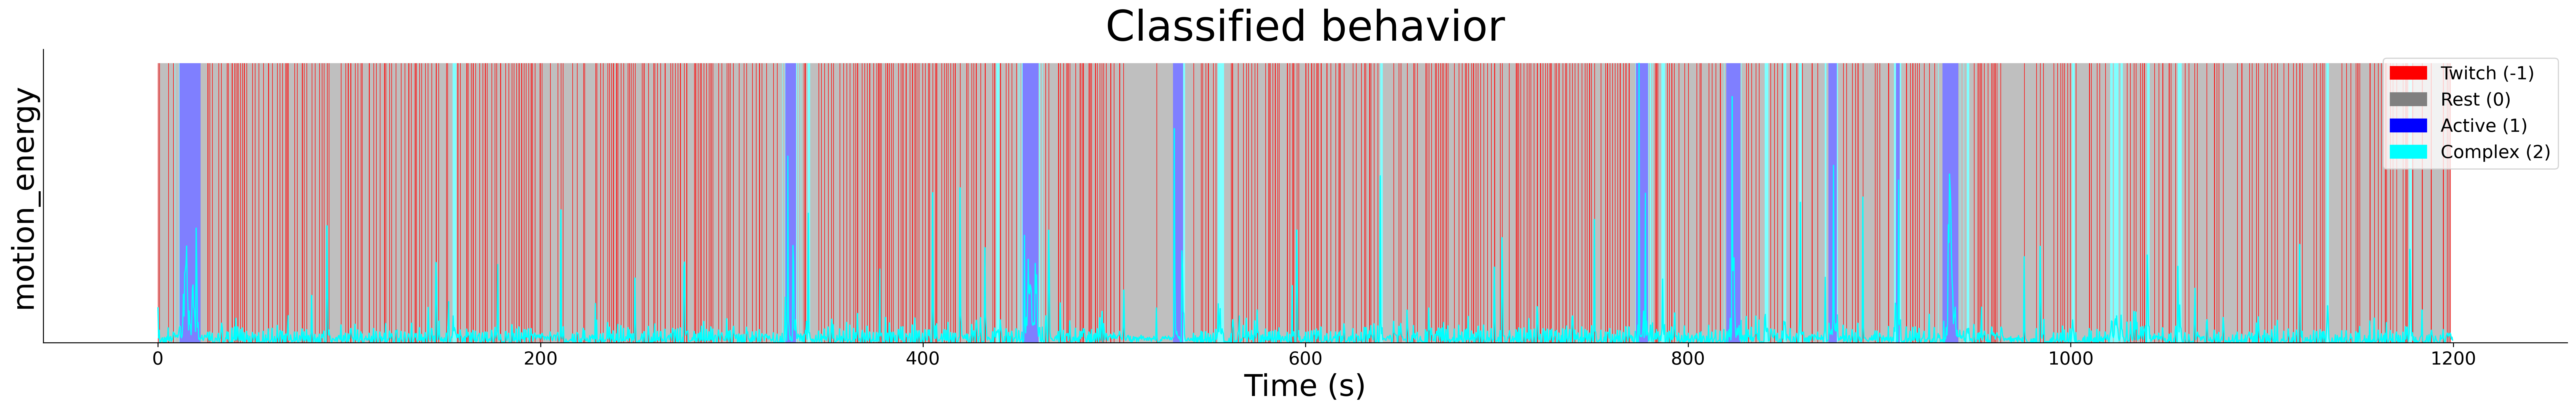

In [76]:
plot_classified_behavior_timeline(classified_behavior, motion_energy, framerate=framerate, save_dir=save_dir_videography)

In [77]:
print(classified_behavior[100:1500])

[ 0  0  0 ...  0  0 -1]


# Save all outputs 

In [78]:
classified_behavior, active_and_complex_motions, only_active_motions, complex_motion_segments, complex_onsets, complex_offsets
auto_detection = {
    'frequency' : framerate,
    # 'binary_threshold' : 'otsu',
    # 'twitch_threshold' : 'li',
    '+- active_motion_min_distance' : twitch_min_distance_from_active/framerate , #sec
    'motion_energy_downsampled_2x' : motion_energy,
    'binary_motion_energy' : bin_motion_energy,

    'classified_behavior': classified_behavior, # np.array: classified behavior (pre-curation): 0,1,-1,2 aka Rest, Active, Twitch, Complex
    
    'active_motion_onsets' : active_motion_onsets,
    'active_motion_offsets' : active_motion_offsets,
    'active_motion_segments' : active_motion_segments,

    'active_and_complex_motions':active_and_complex_motions,
    'only_active_motions':only_active_motions,

    'complex_onsets': complex_onsets,
    'complex_offsets': complex_offsets,
    'complex_motion_segments' : complex_motion_segments, #just (onset,offset)

    'binary_twich':bin_twitch, #binary array where 1 == twitch 
    'inds_twitches_segments': inds_twitches_segments,
    'n_twitches' : n_twitches, # no. of twitches 
    'twitch_onsets': twitch_onsets,  # onsets 
    'twitch_offsets': twitch_offsets  # offsets     
}

np.save(save_dir + f'auto_detection.npy', auto_detection)
# np.savez(save_dir + f"auto_detection_{ds}.npz", **auto_detection) 

In [79]:
# save automatic_annotations

In [80]:
automatic_annotations = {
    'active_onsets': active_motion_onsets,
    'active_offsets': active_motion_offsets,
    'twitch_onsets': twitch_onsets, 
    'twitch_offsets': twitch_offsets,
    'complex_onsets': complex_onsets, 
    'complex_offsets' : complex_offsets,
    'validated_active_onsets': [],
    'validated_active_offsets': [],
    'validated_twitch_onsets': [], 
    'validated_twitch_offsets': [],
    'validated_complex_onsets': [], 
    'validated_complex_offsets' : []
}

# Save as Excel
df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in automatic_annotations.items()]))
df.to_excel(save_dir_videography/'automatic_annotations.xlsx', index=False)

In [81]:
twitch_onsets

array([   0,    2,   16,   24,   78,   81,   85,   95,   99,  108,  110,
        116,  120,  122,  125,  129,  132,  135,  139,  148,  152,  158,
        165,  173,  179,  187,  191,  195,  200,  202,  204,  214,  218,
        226,  229,  233,  241,  246,  253,  257,  260,  265,  268,  287,
        294,  298,  302,  309,  313,  318,  320,  331,  338,  342,  348,
        355,  357,  363,  366,  373,  381,  387,  393,  397,  403,  405,
        410,  413,  419,  423,  429,  436,  440,  452,  454,  470,  474,
        484,  486,  491,  494,  498,  504,  509,  513,  516,  523,  528,
        531,  537,  545,  550,  555,  558,  562,  566,  570,  574,  577,
        581,  585,  587,  591,  599,  602,  615,  627,  632,  635,  650,
        657,  667,  669,  686,  688,  694,  698,  705,  708,  711,  714,
        719,  721,  726,  730,  737,  739,  742,  745,  748,  759,  762,
        769,  777,  779,  783,  788,  795,  804,  807,  811,  815,  819,
        825,  829,  841,  843,  847,  850,  852,  8

In [82]:
twitch_offsets

array([   1,    3,   17,   25,   79,   82,   86,   96,  102,  109,  111,
        117,  121,  123,  127,  130,  133,  136,  140,  149,  153,  159,
        166,  174,  180,  188,  194,  196,  201,  203,  205,  215,  219,
        227,  230,  234,  243,  247,  254,  258,  261,  267,  269,  288,
        295,  299,  304,  310,  314,  319,  321,  332,  339,  343,  349,
        356,  358,  364,  368,  376,  382,  388,  394,  399,  404,  406,
        411,  414,  420,  426,  431,  438,  442,  453,  457,  471,  475,
        485,  487,  492,  495,  499,  505,  510,  514,  517,  525,  530,
        534,  538,  547,  551,  557,  559,  563,  567,  571,  575,  578,
        582,  586,  588,  592,  600,  604,  616,  628,  633,  637,  651,
        660,  668,  670,  687,  689,  695,  699,  706,  709,  712,  715,
        720,  722,  727,  731,  738,  740,  743,  746,  750,  760,  764,
        771,  778,  780,  784,  790,  796,  805,  810,  813,  816,  820,
        828,  832,  842,  844,  849,  851,  853,  8

# Match detected frame indices on the avg back to original time 

In [83]:
rescaled_annotations = {}
for key, value in automatic_annotations.items():
    if len(value) > 0:
        rescaled_annotations[key] = [int(v * scaling_factor) for v in value] # matches avg frame to original frame idx 
    else:
        rescaled_annotations[key] = []

# Convert to DataFrame
df_rescaled = pd.DataFrame({k: pd.Series(v) for k, v in rescaled_annotations.items()})

# Save to Excel
df_rescaled.to_excel(save_dir_videography / 'automatic_annotations_rescaled.xlsx', index=False)

In [84]:
os.getcwd()

'D:\\Users\\Max\\Documents\\mouse_motion_analysis'

In [85]:
## Adjusting script's output (to increase readability and facilitate input to GUI)

# If GUI: (input)

In [86]:
# Prepare motion energy and total frames
n_frames = len(motion_energy_orig)
frame_idx = np.arange(n_frames)

# Initialize binary arrays (0 = not in state, 1 = in state)
active = np.zeros(n_frames, dtype=int)
twitch = np.zeros(n_frames, dtype=int)
complex_ = np.zeros(n_frames, dtype=int)

# Function to fill ranges between onset and offset
def fill_intervals(onsets, offsets, target_array):
    for on, off in zip(onsets, offsets):
        if 0 <= on < off <= n_frames:
            target_array[on:off] = 1
        elif 0 <= on < n_frames:
            target_array[on:] = 1  # In case offset is missing or out of bounds

# Fill activity intervals
fill_intervals(rescaled_annotations.get("active_onsets", []), rescaled_annotations.get("active_offsets", []), active)
fill_intervals(rescaled_annotations.get("twitch_onsets", []), rescaled_annotations.get("twitch_offsets", []), twitch)
fill_intervals(rescaled_annotations.get("complex_onsets", []), rescaled_annotations.get("complex_offsets", []), complex_)

# Create final framewise DataFrame
df_framewise = pd.DataFrame({
    "frame_idx": frame_idx,
    "motion_energy": motion_energy_orig,
    "active": active,
    "twitch": twitch,
    "complex": complex_
})

# Save as CSV for GUI loading
df_framewise.to_csv(save_dir_videography / f'gui_labels.csv', index=False)

In [87]:
save_dir

'D:\\Users\\Max\\Documents\\data_proc\\sz\\cells\\sz089\\2024-06-07_a'

# Write on video for validation (manual curation)

In [88]:
movie_path

'D:\\Users\\Max\\Documents\\data_proc\\sz\\cells\\sz089\\2024-06-07_a\\cam_crop.tif'

In [89]:
# tiff = io.imread(movie_path, plugin='tifffile') #pil loads on snapshot 

# # making sure smallest value of tiff is zero - just a linear transform, shouldn't affect NMF ? 
# tiff -= np.min(tiff)
# print(f'Shape of video: {tiff.shape}')

# LossLess compression (output tiff or avi)

In [90]:
# # Normalize if needed
# tiff = tiff - np.min(tiff)
# tiff = (tiff / tiff.max() * 255).astype(np.uint8)

# # Convert grayscale to BGR if needed
# if len(tiff.shape) == 3:  # (frames, height, width)
#     tiff = np.stack([tiff] * 3, axis=-1)

# # Set up AVI writer
# height, width = tiff.shape[1:3] 
# out = cv2.VideoWriter(
#     'output_video.avi',
#     cv2.VideoWriter_fourcc(*'FFV1'),  # Lossless codec (e.g., FFV1, MJPG, or XVID for near-lossless)
#     15,  # FPS
#     (width, height)
# )

# # Write frames
# for frame in tiff:
#     out.write(frame)
# out.release()
# print("Saved to output_video.avi")

In [91]:
# # Define onset points (from onset_twitch_1d)
# for onset_time in twitch_onsets:
#     # Ensure onset_time is within the frame count
#     if onset_time < len(tiff):
#         frame = tiff[onset_time]
#         frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        
#         # write 'Twitch') at a fixed location (x, y)
#         cv2.putText(frame_bgr, 'Twitch onset', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1, cv2.LINE_AA)

#         tiff[onset_time] = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)

#         # tiff[onset_time] = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)

#         print("Finished marking onset frames.")

# for active_mot_onset in active_motion_onsets: 
#     if active_mot_onset < len(tiff):
#         frame= tiff[active_mot_onset]
#         frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
#         cv2.putText(frame_bgr, 'Active motion onset', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1, cv2.LINE_AA)
#         tiff[active_mot_onset] = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY) 

# for active_motion_offset in active_motion_offsets:
#     if active_motion_offset < len(tiff):
#         frame = tiff[active_motion_offset]
#         frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
#         cv2.putText(frame_bgr, 'Active motion offset', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1, cv2.LINE_AA)
#         tiff[active_motion_offset] = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)   

# for complex_motion_onset in complex_onsets:
#     if complex_motion_onset < len(tiff):
#         frame=tiff[complex_motion_onset]
#         frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
#         cv2.putText(frame_bgr, 'Complex motion', (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1, cv2.LINE_AA)
#         tiff[complex_motion_onset] = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    

In [92]:
# output_dir = save_dir_videography / '_validation_twitch_video.tif'
# # Export the marked frames as TIFF sequence
# os.makedirs(output_dir, exist_ok=True)

# # Save frames as TIFF files
# for i, frame in enumerate(tiff):
#     output_path = os.path.join(output_dir, f"frame_{i:04d}.tiff")
#     img = Image.fromarray(frame)
#     img.save(output_path)
    

# print(f"Exported {len(tiff)} frames to {output_dir}")